# Rock Paper Scissors

## Import Library

In [1]:
import os
# Konfigurasi TensorFlow agar tidak menampilkan log yang mengganggu
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [31]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder

In [17]:
# Fungsi untuk mencari path file src\models\mlp_model.keras dari src\notebook\training.ipynb
def get_model_path():
    current_dir = os.getcwd() # Mendapatkan path direktori saat ini
    current_dir = os.path.dirname(current_dir) # Pindah ke direktori sebelumnya
    
    # Pindah ke direktori src\models\mlp_model.keras
    model_path = os.path.join(current_dir, 'models', 'mlp_model.keras')
    return model_path

MODEL_PATH = get_model_path()
MODEL_PATH

'c:\\Users\\fedba\\Downloads\\RockPaperScissor\\src\\models\\mlp_model.keras'

In [18]:
# Fungsi untuk mencari path file src\artifacts\history.csv dari src\notebook\training.ipynb
def get_history_path():
    current_dir = os.getcwd() # Mendapatkan path direktori saat ini
    current_dir = os.path.dirname(current_dir) # Pindah ke direktori sebelumnya
    
    # Pindah ke direktori src\artifacts\history.csv
    history_path = os.path.join(current_dir, 'artifacts', 'history.csv')
    return history_path

HISTORY_PATH = get_history_path()


'c:\\Users\\fedba\\Downloads\\RockPaperScissor\\src\\artifacts\\history.csv'

In [12]:
# Fungsi untuk mencari path file src\data\augmented_dataset.csv dari src\notebook\training.ipynb
def get_dataset_path():
    current_path = os.getcwd() # Mendapatkan current working directory src\notebook\training.ipynb
    current_path = os.path.dirname(current_path) # Pindah ke src\notebook
    
    # Pindah ke src\data
    dataset_path = os.path.join(current_path, 'data')
    # Pindah ke src\data\augmented_dataset.csv
    dataset_path = os.path.join(dataset_path, 'augmented_dataset.csv')

    return dataset_path


# Fungsi untuk memuat dataset
def load_dataset():
    dataset_path = get_dataset_path()
    return pd.read_csv(dataset_path)


dataset = load_dataset()
dataset.head()


,feature1,feature2,label
0,0.5,1.0,1.0
1,0.5,0.0,0.0
2,0.5,0.5,0.5
3,0.0,0.5,1.0
4,0.0,1.0,0.0


In [13]:
X_train, y_train = dataset.iloc[:, :-1], dataset.iloc[:, -1]
y_train = to_categorical(y_train, num_classes=3)

## Membuat model

In [14]:
model = keras.Sequential([
    keras.Input(shape=(2,)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Dropout(0.4),  # Dropout lebih tinggi
    keras.layers.BatchNormalization(), # Tambahkan Batch Normalization
    keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Dropout(0.3),  # Tambahkan dropout lagi
    keras.layers.BatchNormalization(), # Tambahkan Batch Normalization
    keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Dropout(0.2),  # Dropout lebih kecil di layer akhir
    keras.layers.BatchNormalization(), # Tambahkan Batch Normalization
    keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),  
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,299 (12.89 KB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 224 (896.00 B)

## Training Model

In [20]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    epochs=200, 
                    verbose=1,  # Gunakan verbose=1 untuk melihat progres training
                    validation_split=0.3,  # 30% data untuk validasi
                    callbacks=[early_stopping, lr_scheduler
                                ])

# Simpan model dan history
#model.save(MODEL_PATH)
history_df = pd.DataFrame(history.history)
#history_df.to_csv(HISTORY_PATH, index=False)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.3484 - loss: 2.2750 - val_accuracy: 0.3221 - val_loss: 1.7637 - learning_rate: 0.0010
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3997 - loss: 2.0637 - val_accuracy: 0.5638 - val_loss: 1.6820 - learning_rate: 0.0010
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4183 - loss: 1.9282 - val_accuracy: 0.7651 - val_loss: 1.6122 - learning_rate: 0.0010
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4407 - loss: 1.9146 - val_accuracy: 0.6711 - val_loss: 1.5537 - learning_rate: 0.0010
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4921 - loss: 1.7646 - val_accuracy: 0.6711 - val_loss: 1.5088 - learning_rate: 0.0010
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5362 - loss: 1.6512 - val_accuracy: 0.6711 - val_loss: 1.4650 - learning_rate: 0.0010
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5555 - loss: 1.5767 - 

## Evaluasi Model

In [22]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)

Training & Validation Loss and Accuracy
 accuracy: 0.9971, val_accuracy: 1.0000


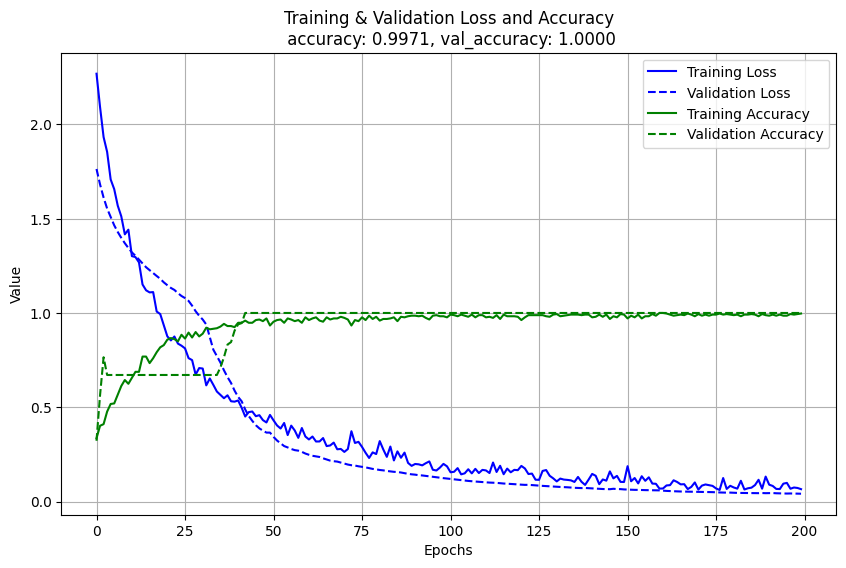

In [24]:
plt.figure(figsize=(10, 6))

# Plot Loss
plt.plot(history_df['loss'], label='Training Loss', color='blue')
plt.plot(history_df['val_loss'], label='Validation Loss', color='blue', linestyle='dashed')

# Plot Accuracy
plt.plot(history_df['accuracy'], label='Training Accuracy', color='green')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy', color='green', linestyle='dashed')

last_value = history_df.iloc[-1]
title = f"Training & Validation Loss and Accuracy\n accuracy: {last_value['accuracy']:.4f}, val_accuracy: {last_value['val_accuracy']:.4f}"
print(title)
plt.title(title)
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
#plt.savefig("history_plot.png")
plt.show()

## Testing Model

In [26]:
choices = ['rock', 'paper', 'scissors']


In [ ]:
le = LabelEncoder()
le.fit(choices)

# Statistik Game
stats = {"win": 0, "draw": 0, "lose": 0}
randomness = 0.3

In [28]:
# Statistik Game
stats = {"win": 0, "draw": 0, "lose": 0}
randomness = 0.3


In [33]:
def play_against_ai(player_choice):
    """Fungsi untuk bermain melawan AI berdasarkan model yang telah dilatih."""
    if player_choice not in choices:
        print("Pilihan tidak valid! Pilih: rock, paper, atau scissors")
        return

    scores = {choice: model.predict(np.array([[le.transform([choice])[0], le.transform([player_choice])[0]]]))[0][0] for choice in choices}
    ai_choice = random.choice(choices) if random.random() < randomness else max(scores, key=scores.get)

    print(f"\nAnda memilih: {player_choice}")
    print(f"AI memilih: {ai_choice} (Confidence: {scores[ai_choice]:.2%})")

    if ai_choice == player_choice:
        print("Hasil SERI!"); stats["draw"] += 1
    elif (player_choice == 'rock' and ai_choice == 'scissors') or \
         (player_choice == 'scissors' and ai_choice == 'paper') or \
         (player_choice == 'paper' and ai_choice == 'rock'):
        print("Anda MENANG!"); stats["win"] += 1
    else:
        print("AI MENANG!"); stats["lose"] += 1

    print(f"Statistik Saat Ini: Menang: {stats['win']}, Seri: {stats['draw']}, Kalah: {stats['lose']}")

In [34]:
for _ in range(5):
    player_choice = random.choice(choices)
    play_against_ai(player_choice)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Anda memilih: paper
AI memilih: paper (Confidence: 99.92%)
Hasil SERI!
Statistik Saat Ini: Menang: 0, Seri: 1, Kalah: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Anda memilih: rock
AI memilih: rock (Confidence: 99.87%)
Hasil SERI!
Statistik Saat Ini: Menang: 0, Seri: 2, Kalah: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Anda memilih: scissors
AI memilih: paper (Confidence: 100.00%)
Anda MENANG!
Statistik Saat Ini: Menang: 1, Seri: 2, Kalah: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

Anda memilih: paper
AI memilih: scissors (Confidence: 0.00%)
AI MENANG!
Statistik Saat Ini: Menang: 1, Seri: 2, Kalah: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━